# Set up data set (MNIST) and device

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
import numpy as np

train_set_MNIST = torchvision.datasets.MNIST(
  root="./",
  download=True,
  train=True,
  transform=transforms.Compose([transforms.ToTensor()]),
)

test_set_MNIST = torchvision.datasets.MNIST(
  root="./",
  download=True,
  train=False,
  transform=transforms.Compose([transforms.ToTensor()]),
)

train_set_MNIST = data_utils.Subset(train_set_MNIST, torch.arange(10000))
test_set_MNIST = data_utils.Subset(test_set_MNIST, torch.arange(10000))

def loading_data(batch_size, train_set, test_set):
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
    return trainloader, testloader

batch_size = 512
trainloader, testloader = loading_data(batch_size, train_set_MNIST, test_set_MNIST)

/Users/wkc/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
dtype = torch.float
device = torch.device("mps")

# Train function

In [3]:
def TrainSNN(net, nepochs=1, print_epoch=True, plot_mem=False, break_after_convergence=True):
    num_steps = net.num_steps
    num_epochs = nepochs
    
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999))

    prev_train_loss = np.inf   # For later use.
    converged = False
    nepochs_to_converge = nepochs   # No. of epochs to converge.

    train_loss_rec = []
    test_loss_rec = []
    train_acc_rec = []
    test_acc_rec = []

    for epoch in range(num_epochs):
        trainbatch = iter(trainloader)

        train_loss = 0   # Initialize losses.
        test_loss = 0

        for idx, (data, targets) in enumerate(trainbatch):
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass.
            spk_rec, mem_rec = net(data)

            # Initialize train loss and sum over time.
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                loss_val += loss(mem_rec[step], targets)

            # Backward pass.
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            train_loss += loss_val.item()

            # Test set.
            with torch.no_grad():
                net.eval()
                test_data, test_targets = next(iter(testloader))
                test_data = test_data.to(device)
                test_targets = test_targets.to(device)

                # Test set forward pass.
                test_spk, test_mem = net(test_data)

                # Test set loss.
                loss_val = torch.zeros((1), dtype=dtype, device=device)
                for step in range(num_steps):
                    loss_val += loss(test_mem[step], test_targets)

                test_loss += loss_val.item()

            if plot_mem: # Plot output layer membrane potentials.
                if idx == 0:
                    for i in range(10):
                        plt.plot(mem_rec[:,0,i].detach().cpu().numpy())
                        plt.xlabel("Time Step")
                        plt.ylabel("Membrane Potential (V)")
                        plt.grid()
                        plt.show()      

        # Train set accuracy.
        _, preds = spk_rec.sum(dim=0).max(1)
        train_acc = np.mean((targets == preds).detach().cpu().numpy())                              

        # Test set accuracy.
        _, preds = test_spk.sum(dim=0).max(1)
        test_acc = np.mean((test_targets == preds).detach().cpu().numpy())

        if print_epoch:   # Print epoch, losses, and test accuracy.
            print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.04} | Test Loss: {test_loss:.04} | Train Accuracy: {train_acc*100:.2f}% | Test Accuracy: {test_acc*100:.2f}%')

        train_loss_rec.append(train_loss)
        test_loss_rec.append(test_loss)
        train_acc_rec.append(train_acc*100)
        test_acc_rec.append(test_acc*100)

        if np.abs(prev_train_loss - train_loss) < 0.10 and not converged:   # Convergence.  
            converged = True
            nepochs_to_converge = epoch+1
            if print_epoch:
                print("-"*75, f"Converged after {nepochs_to_converge} epochs")
            if break_after_convergence:
                break


        prev_train_loss = train_loss
            
    return nepochs_to_converge, train_loss_rec, test_loss_rec, train_acc_rec, test_acc_rec

# Models

### Leaky

In [4]:
class Leaky(nn.Module):
    def __init__(self, beta=0.8, threshold=1.0):
        super(Leaky, self).__init__()
        self.beta = beta
        self.threshold = threshold
        self.spike_gradient = self.FastSig.apply

    def forward(self, input_, mem, timestep):
        spk = self.spike_gradient((mem-self.threshold))
        reset = (spk * self.threshold).detach()
        mem = self.beta * mem + input_ - reset
        return spk, mem

    @staticmethod
    class FastSig(torch.autograd.Function):
        @staticmethod
        def forward(ctx, mem):
            spk = (mem > 0).float()
            spk = spk.to(device)
            ctx.save_for_backward(mem)
            return spk

        @staticmethod
        def backward(ctx, grad_output):
            (mem,) = ctx.saved_tensors
            grad = 1 / (1 + np.pi * torch.abs(mem))**2 * grad_output
            return grad

class LeakyNet(nn.Module):
    def __init__(self, dim=784, nclass=10, width=1000, depth=1, num_steps=15):
        super().__init__()
        self.dim = dim
        self.width = width
        self.depth = depth
        self.nclass = nclass
        self.num_steps = num_steps

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(dim, width)
        self.fc2 = nn.ModuleList([nn.Linear(width, width) for _ in range(self.depth-1)])    
        self.fc3 = nn.Linear(width, nclass)
        self.lif = Leaky()

    def forward(self, input):
        cur_batch_size = input.shape[0]

        # Initialize membrane potentials: 
        # mem1: hidden layers excl. last; mem2: last hidden layer; mem3: output layer.
        mem1 = [torch.zeros(cur_batch_size, self.width, device=device) for _ in range(self.depth-1)]
        mem2 = torch.zeros(cur_batch_size, self.width, device=device) 
        mem3 = torch.zeros(cur_batch_size, self.nclass, device=device)

        spk3_rec = []   # Final spike record.
        mem3_rec = []   # Final membrane record.

        for step in range(self.num_steps):
            input_ = self.flatten(input)
            cur = self.fc1(input_)

            for j in range(self.depth-1): 
                spk, mem1[j] = self.lif(cur, mem1[j], step)
                cur = self.fc2[j](spk)

            spk, mem2 = self.lif(cur, mem2, step)
            cur = self.fc3(spk)            

            spk3, mem3 = self.lif(cur, mem3, step)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

### LTC

In [5]:
class LTC(nn.Module):
    def __init__(self, beta=0.8, A=1, K=1, threshold=1.0):
        super(LTC, self).__init__()
        self.beta = beta
        self.A = A
        self.K = K
        self.threshold = threshold
        self.spike_gradient = self.FastSig.apply

    def forward(self, input_, mem, timestep):
        spk = self.spike_gradient((mem-self.threshold))
        reset = (spk * self.threshold).detach()
        mem = (self.beta-self.K*torch.sigmoid(input_)) * mem + self.A * self.K*torch.sigmoid(input_) - reset
        return spk, mem

    @staticmethod
    class FastSig(torch.autograd.Function):
        @staticmethod
        def forward(ctx, mem):
            spk = (mem > 0).float()
            spk = spk.to(device)
            ctx.save_for_backward(mem)
            return spk

        @staticmethod
        def backward(ctx, grad_output):
            (mem,) = ctx.saved_tensors
            grad = 1 / (1 + np.pi * torch.abs(mem))**2 * grad_output
            return grad

class LTCNet(nn.Module):
    def __init__(self, dim=784, nclass=10, width=1000, depth=1, num_steps=15, A=1, K=1):
        super().__init__()
        self.dim = dim
        self.width = width
        self.depth = depth
        self.nclass = nclass
        self.num_steps = num_steps
        self.A = A
        self.K = K

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(dim, width)
        self.fc2 = nn.ModuleList([nn.Linear(width, width) for _ in range(self.depth-1)])    
        self.fc3 = nn.Linear(width, nclass)
        self.ltc = LTC(A=self.A, K=self.K)

    def forward(self, input):
        cur_batch_size = input.shape[0]

        # Initialize membrane potentials: 
        # mem1: hidden layers excl. last; mem2: last hidden layer; mem3: output layer
        mem1 = [torch.zeros(cur_batch_size, self.width, device=device) for _ in range(self.depth-1)]
        mem2 = torch.zeros(cur_batch_size, self.width, device=device) 
        mem3 = torch.zeros(cur_batch_size, self.nclass, device=device)

        spk3_rec = []   # Final spike record.
        mem3_rec = []   # Final membrane record.

        for step in range(self.num_steps):
            input_ = self.flatten(input)
            cur = self.fc1(input_)

            for j in range(self.depth-1): 
                spk, mem1[j] = self.ltc(cur, mem1[j], step)
                cur = self.fc2[j](spk)

            spk, mem2 = self.ltc(cur, mem2, step)
            cur = self.fc3(spk)            

            spk3, mem3 = self.ltc(cur, mem3, step)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

### LIF2D

In [6]:
class LIF2D(nn.Module):
    def __init__(self, beta=0.8, B0=1, B1=1, threshold=1.0):
        super(LIF2D, self).__init__()
        self.beta = beta
        self.B0 = B0
        self.B1 = B1
        self.threshold = threshold
        self.spike_gradient = self.FastSig.apply

    def forward(self, input_, mem, gat, timestep):
        spk = self.spike_gradient((mem-self.threshold))
        reset = (spk * self.threshold).detach()
        mem = self.beta * mem + input_ - gat - reset
        gat = self.B0 * gat + self.B1 * mem
        return spk, mem, gat

    @staticmethod
    class FastSig(torch.autograd.Function):
        @staticmethod
        def forward(ctx, mem):
            spk = (mem > 0).float()
            spk = spk.to(device)
            ctx.save_for_backward(mem)
            return spk

        @staticmethod
        def backward(ctx, grad_output):
            (mem,) = ctx.saved_tensors
            grad = 1 / (1 + np.pi * torch.abs(mem))**2 * grad_output
            return grad

class LIF2DNet(nn.Module):
    def __init__(self, dim=784, nclass=10, width=1000, depth=1, num_steps=15, B0=1, B1=1):
        super().__init__()
        self.dim = dim
        self.width = width
        self.depth = depth
        self.nclass = nclass
        self.num_steps = num_steps
        self.B0 = B0
        self.B1 = B1

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(dim, width)
        self.fc2 = nn.ModuleList([nn.Linear(width, width) for _ in range(self.depth-1)])    
        self.fc3 = nn.Linear(width, nclass)
        self.lif2D = LIF2D(B0=self.B0, B1=self.B1)

    def forward(self, input):
        cur_batch_size = input.shape[0]

        # Initialize membrane potentials: 
        # mem1: hidden layers excl. last; mem2: last hidden layer; mem3: output layer
        mem1 = [torch.zeros(cur_batch_size, self.width, device=device) for _ in range(self.depth-1)]
        mem2 = torch.zeros(cur_batch_size, self.width, device=device) 
        mem3 = torch.zeros(cur_batch_size, self.nclass, device=device) 

        gat1 = [torch.ones(cur_batch_size, self.width, device=device) for _ in range(self.depth-1)]
        gat2 = torch.ones(cur_batch_size, self.width, device=device) 
        gat3 = torch.ones(cur_batch_size, self.nclass, device=device) 

        spk3_rec = []
        mem3_rec = []

        for step in range(self.num_steps):
            input_ = self.flatten(input)
            cur = self.fc1(input_)

            for j in range(self.depth-1): 
                spk, mem1[j], gat1[j] = self.lif2D(cur, mem1[j], gat1[j], step)
                cur = self.fc2[j](spk)

            spk, mem2, gat2 = self.lif2D(cur, mem2, gat2, step)
            cur = self.fc3(spk)

            spk3, mem3, gat3 = self.lif2D(cur, mem3, gat3, step)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

# Tests

### Convergence

In [60]:
trials = 5

In [63]:
# Leaky
sum_nepochs = 0
sum_trainloss = 0
sum_testloss = 0
sum_trainacc = 0
sum_testacc = 0
for _ in range(trials):
    net = LeakyNet(dim=784, nclass=10, width=1000, depth=1, num_steps=15).to(device)    
    nepochs_to_converge, train_loss_rec, test_loss_rec, train_acc_rec, test_acc_rec = TrainSNN(net, nepochs = 100, print_epoch=False)
    sum_nepochs += nepochs_to_converge
    sum_trainloss += train_loss_rec[-1]
    sum_testloss += test_loss_rec[-1]
    sum_trainacc += train_acc_rec[-1]
    sum_testacc += test_acc_rec[-1]

print(sum_nepochs/trials)
print(sum_trainloss/trials)
print(sum_testloss/trials)
print(sum_trainacc/trials)
print(sum_testacc/trials)

14.8
47.315822172164914
105.65572762489319
97.35294117647058
93.671875


In [64]:
# LTC
sum_nepochs = 0
sum_trainloss = 0
sum_testloss = 0
sum_trainacc = 0
sum_testacc = 0
for _ in range(trials):
    net = LTCNet(dim=784, nclass=10, width=1000, depth=1, num_steps=15, A=8, K=0.2).to(device)    
    nepochs_to_converge, train_loss_rec, test_loss_rec, train_acc_rec, test_acc_rec = TrainSNN(net, nepochs = 100, print_epoch=False)
    sum_nepochs += nepochs_to_converge
    sum_trainloss += train_loss_rec[-1]
    sum_testloss += test_loss_rec[-1]
    sum_trainacc += train_acc_rec[-1]
    sum_testacc += test_acc_rec[-1]

print(sum_nepochs/trials)
print(sum_trainloss/trials)
print(sum_testloss/trials)
print(sum_trainacc/trials)
print(sum_testacc/trials)

41.8
356.6520206451416
373.36717262268064
98.67647058823529
95.15625


In [65]:
# LIF2D
sum_nepochs = 0
sum_trainloss = 0
sum_testloss = 0
sum_trainacc = 0
sum_testacc = 0
for _ in range(trials):
    net = LIF2DNet(dim=784, nclass=10, width=1000, depth=1, num_steps=15, B0=0.5, B1=0.5).to(device)    
    nepochs_to_converge, train_loss_rec, test_loss_rec, train_acc_rec, test_acc_rec = TrainSNN(net, nepochs = 100, print_epoch=False)
    sum_nepochs += nepochs_to_converge
    sum_trainloss += train_loss_rec[-1]
    sum_testloss += test_loss_rec[-1]
    sum_trainacc += train_acc_rec[-1]
    sum_testacc += test_acc_rec[-1]

print(sum_nepochs/trials)
print(sum_trainloss/trials)
print(sum_testloss/trials)
print(sum_trainacc/trials)
print(sum_testacc/trials)

15.8
46.57458500862121
95.56088047027588
96.1029411764706
91.7578125


### Width, depth, and time tests

In [53]:
np.linspace(100, 1500, 8, dtype=int) 

array([ 100,  300,  500,  700,  900, 1100, 1300, 1500])

In [13]:
import time
width_range = np.linspace(100, 1500, 8, dtype=int) 
depth_range = np.linspace(1, 5, 5, dtype=int)

In [14]:
# Leaky
mat_nepochs = np.zeros((width_range.size, depth_range.size))
mat_trainloss = np.zeros((width_range.size, depth_range.size))
mat_testloss = np.zeros((width_range.size, depth_range.size))
mat_trainacc = np.zeros((width_range.size, depth_range.size))
mat_testacc = np.zeros((width_range.size, depth_range.size))
mat_time = np.zeros((width_range.size, depth_range.size))

for row, width in enumerate(width_range):
    print(row)
    for col, depth in enumerate(depth_range):
        T1 = time.time()
        net = LeakyNet(dim=784, nclass=10, width=width, depth=depth, num_steps=15).to(device)    
        nepochs_to_converge, train_loss_rec, test_loss_rec, train_acc_rec, test_acc_rec = TrainSNN(net, nepochs = 100, print_epoch=False)
        T2 = time.time()
        mat_nepochs[row][col] = nepochs_to_converge      
        mat_trainloss[row][col] = train_loss_rec[-1]      
        mat_testloss[row][col] = test_loss_rec[-1]     
        mat_trainacc[row][col] = train_acc_rec[-1]
        mat_testacc[row][col] = test_acc_rec[-1]
        mat_time[row][col] = T2-T1

0
1
2
3
4
5
6
7


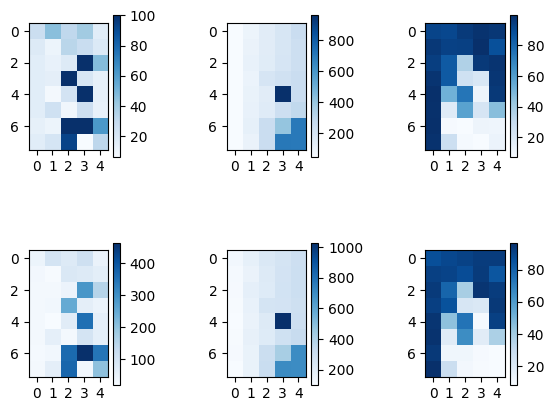

In [48]:
plt.subplot(2, 3, 1)
plt.imshow(mat_nepochs, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])

plt.subplot(2, 3, 2)
plt.imshow(mat_trainloss, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 3)
plt.imshow(mat_trainacc, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 4)
plt.imshow(mat_time, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 5)
plt.imshow(mat_testloss, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 6)
plt.imshow(mat_testacc, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])

plt.subplots_adjust(wspace=1.0, hspace=0.6)


In [49]:
# LTC
mat_nepochs = np.zeros((width_range.size, depth_range.size))
mat_trainloss = np.zeros((width_range.size, depth_range.size))
mat_testloss = np.zeros((width_range.size, depth_range.size))
mat_trainacc = np.zeros((width_range.size, depth_range.size))
mat_testacc = np.zeros((width_range.size, depth_range.size))
mat_time = np.zeros((width_range.size, depth_range.size))

for row, width in enumerate(width_range):
    print(row)
    for col, depth in enumerate(depth_range):
        T1 = time.time()
        net = LTCNet(dim=784, nclass=10, width=width, depth=depth, num_steps=15, A=8, K=0.2).to(device)    
        nepochs_to_converge, train_loss_rec, test_loss_rec, train_acc_rec, test_acc_rec = TrainSNN(net, nepochs = 100, print_epoch=False)
        T2 = time.time()
        mat_nepochs[row][col] = nepochs_to_converge      
        mat_trainloss[row][col] = train_loss_rec[-1]      
        mat_testloss[row][col] = test_loss_rec[-1]     
        mat_trainacc[row][col] = train_acc_rec[-1]
        mat_testacc[row][col] = test_acc_rec[-1]
        mat_time[row][col] = T2-T1

0
1
2
3
4
5
6
7


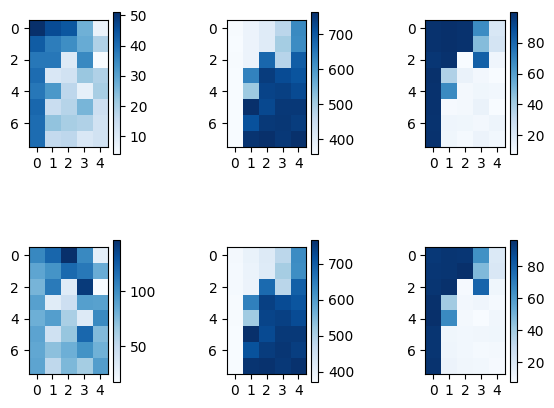

In [50]:
plt.subplot(2, 3, 1)
plt.imshow(mat_nepochs, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])

plt.subplot(2, 3, 2)
plt.imshow(mat_trainloss, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 3)
plt.imshow(mat_trainacc, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 4)
plt.imshow(mat_time, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 5)
plt.imshow(mat_testloss, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 6)
plt.imshow(mat_testacc, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])

plt.subplots_adjust(wspace=1.0, hspace=0.6)


In [51]:
# LIF2D
mat_nepochs = np.zeros((width_range.size, depth_range.size))
mat_trainloss = np.zeros((width_range.size, depth_range.size))
mat_testloss = np.zeros((width_range.size, depth_range.size))
mat_trainacc = np.zeros((width_range.size, depth_range.size))
mat_testacc = np.zeros((width_range.size, depth_range.size))
mat_time = np.zeros((width_range.size, depth_range.size))

for row, width in enumerate(width_range):
    print(row)
    for col, depth in enumerate(depth_range):
        T1 = time.time()
        net = LIF2DNet(dim=784, nclass=10, width=width, depth=depth, num_steps=15, B0=0.5, B1=0.5).to(device)    
        nepochs_to_converge, train_loss_rec, test_loss_rec, train_acc_rec, test_acc_rec = TrainSNN(net, nepochs = 100, print_epoch=False)
        T2 = time.time()
        mat_nepochs[row][col] = nepochs_to_converge      
        mat_trainloss[row][col] = train_loss_rec[-1]      
        mat_testloss[row][col] = test_loss_rec[-1]     
        mat_trainacc[row][col] = train_acc_rec[-1]
        mat_testacc[row][col] = test_acc_rec[-1]
        mat_time[row][col] = T2-T1

0
1
2
3
4
5
6
7


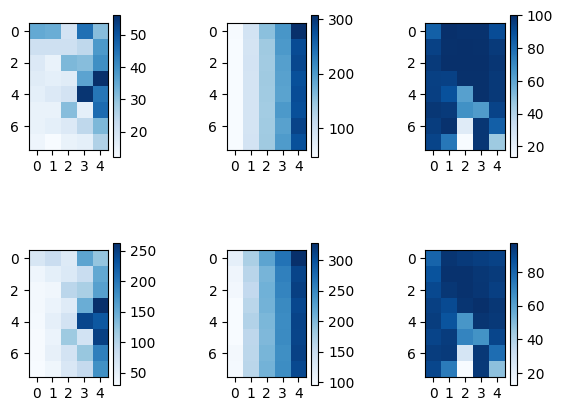

In [52]:
plt.subplot(2, 3, 1)
plt.imshow(mat_nepochs, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])

plt.subplot(2, 3, 2)
plt.imshow(mat_trainloss, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 3)
plt.imshow(mat_trainacc, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 4)
plt.imshow(mat_time, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 5)
plt.imshow(mat_testloss, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])


plt.subplot(2, 3, 6)
plt.imshow(mat_testacc, cmap='Blues')
plt.colorbar()
plt.xticks([0,1,2,3,4])

plt.subplots_adjust(wspace=1.0, hspace=0.6)


### LTC membrane plots

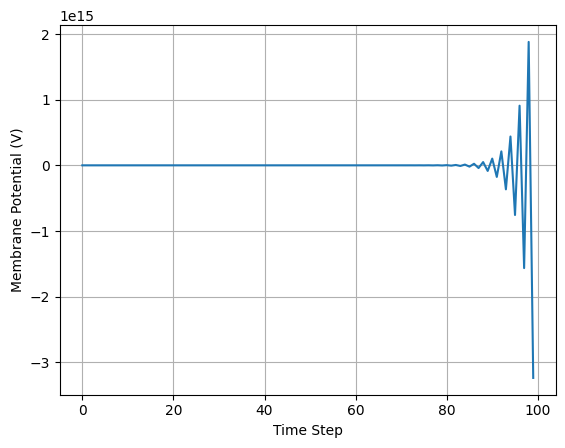

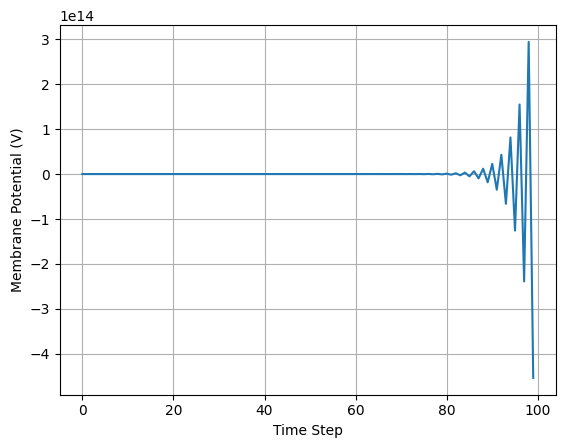

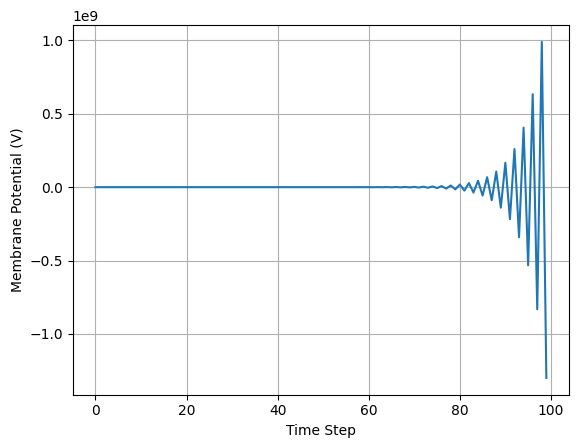

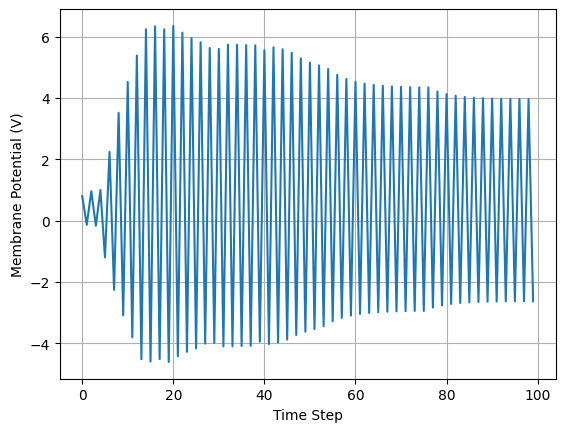

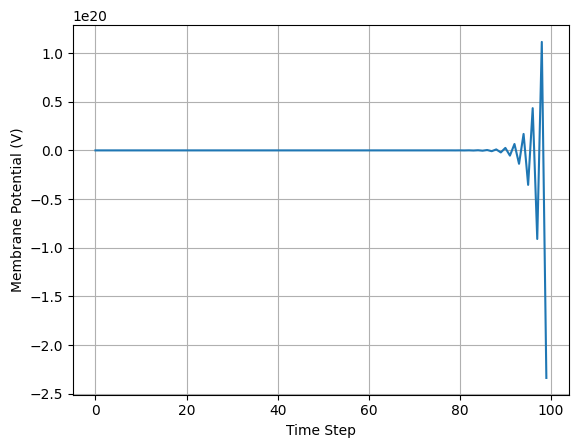

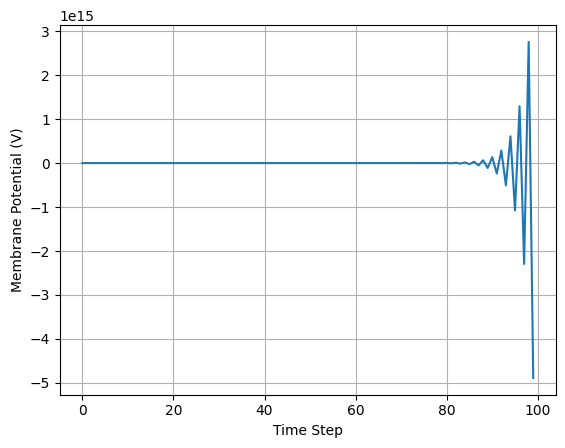

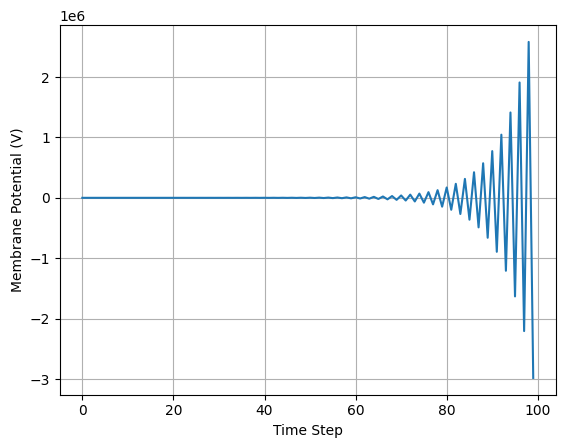

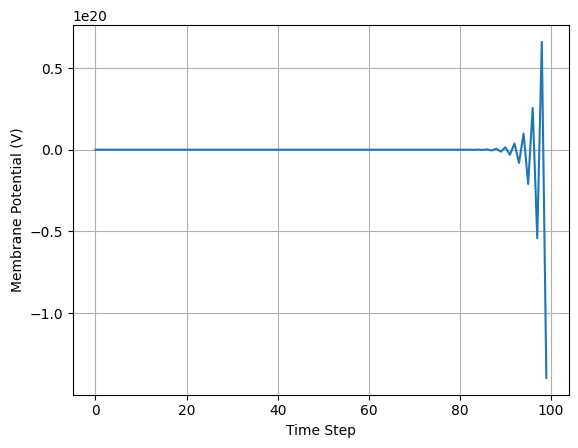

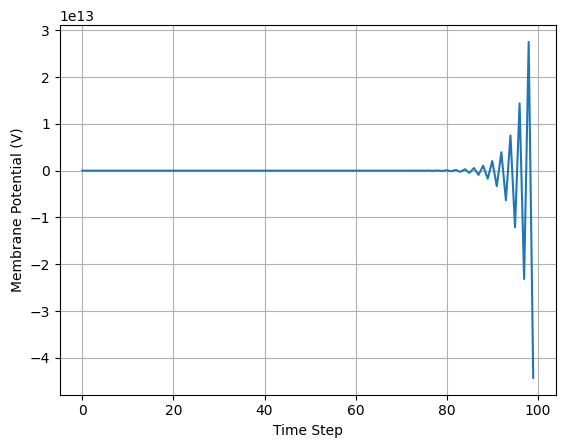

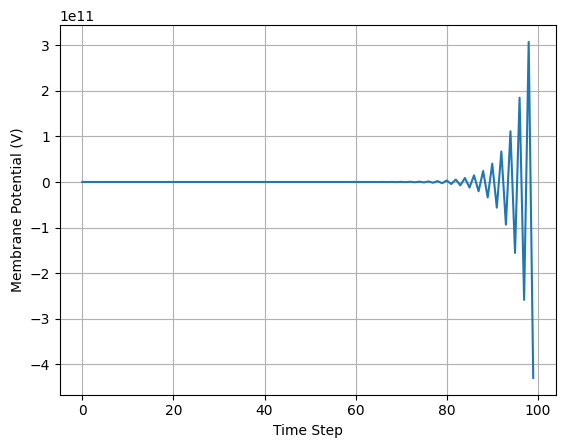

Epoch: 1 | Train Loss: 1.96e+29 | Test Loss: 1.975e+29 | Test Accuracy: 14.65%


(1, [1.9595117554673003e+29], [1.975422568182167e+29], [14.6484375])

In [412]:
net = LTCNet(dim=784, nclass=10, width=1000, num_steps=100 , A=0.4, K=4).to(device)
TrainSNN(net, nepochs = 1, plot_mem=True)

### LTC grid searches

In [ ]:
# Large heatmap.
A_range = np.linspace(0, 10.0, 101)
K_range = np.linspace(0, 3.0, 101)
LTCmat = np.zeros((A_range.size, K_range.size))

for i, A in enumerate(A_range):
    print(i)
    for j, K in enumerate(K_range):
        net = LTCNet(A=A, K=K).to(device)
        _, _, _, acc_rec = TrainSNN(net, nepochs = 1, print_epoch=False)
        LTCmat[i,j] = acc_rec[-1]

plt.imshow(LTCmat[::-1], cmap='hot', vmin = 0, vmax = 100)
plt.colorbar()
plt.show()

In [ ]:
# Optimal search.
A_range = np.linspace(0, 10.0, 101)   # 0.1 increment.
K_range = np.linspace(0, 3.0, 31)   # 0.1 increment.
LTCopt = np.zeros((A_range.size, K_range.size))

for i, A in enumerate(A_range):
    if i % 10 == 0:
        print(i)
    for j, K in enumerate(K_range):
        net = LTCNet(dim=784, nclass=10, width=1000, num_steps=15, A=A, K=K).to(device)
        _, _, _, acc_rec = TrainSNN(net, nepochs = 1, print_epoch=False)
        LTCopt[i,j] = acc_rec[-1]

for i, A in enumerate(A_range):
    for j, K in enumerate(K_range):
        if LTCopt[i,j] > 60:
            net = LTCNet(dim=784, nclass=10, width=1000, num_steps=15, A=A, K=K).to(device)
            LTCopt[i,j] = TrainSNN(net, nepochs = 10, print_epoch=False)
            _, _, _, acc_rec = TrainSNN(net, nepochs = 1, print_epoch=False)
            LTCopt[i,j] = acc_rec[-1]
        else:
            LTCopt[i,j] = 0

print(np.amax(LTCopt))
indices = np.where(LTCopt > 95)
indices


/var/folders/67/pvz9wvl16ylch79dlmcs3fy00000gn/T/ipykernel_15503/4088205249.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  if np.abs(y - 0.5/(x - 0.)) < 0.1:


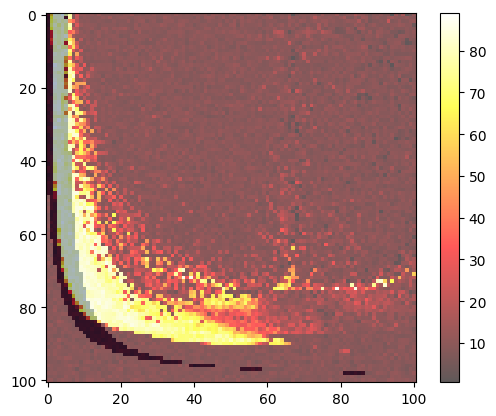

In [406]:
# Graph fitting.
x_range = np.linspace(0, 10.0, 101)
y_range = np.linspace(0, 3.0, 101)
mat = np.zeros((x_range.size, y_range.size))

for i, x in enumerate(x_range):
    for j, y in enumerate(y_range):
        if np.abs(y - 0.5/(x - 0.)) < 0.1:
            mat[i,j] = 1

plt.imshow(mat[::-1], cmap='Blues')
plt.imshow(LTCmat[::-1], cmap='hot', alpha=0.65)
plt.colorbar()
plt.show()


### LIF2D grid searches

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


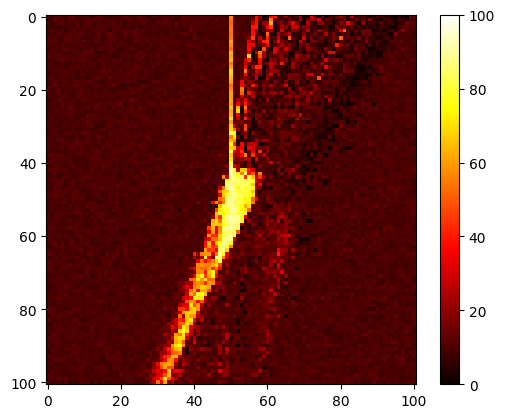

In [44]:
# Large heatmap.
B0_range = np.linspace(-5, 5, 101)
B1_range = np.linspace(-12, 12.0, 101)
LIF2Dmat = np.zeros((B0_range.size, B1_range.size))

for i, B0 in enumerate(B0_range):
    print(i)
    for j, B1 in enumerate(B1_range):
        net = LIF2DNet(B0=B0, B1=B1).to(device)
        _, _, _, acc_rec = TrainSNN(net, nepochs = 1, print_epoch=False)
        LIF2Dmat[i,j] = acc_rec[-1]

plt.imshow(LIF2Dmat[::-1], cmap='hot', vmin = 0, vmax = 100)
plt.colorbar()
plt.show()

In [56]:
np.linspace(-2, 2, 41)
np.linspace(-6, 6, 121)

array([-6. , -5.9, -5.8, -5.7, -5.6, -5.5, -5.4, -5.3, -5.2, -5.1, -5. ,
       -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. , -3.9,
       -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3. , -2.9, -2.8,
       -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7,
       -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6,
       -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,
        0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,
        1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,
        2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,
        3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,
        5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ])

0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
96.875


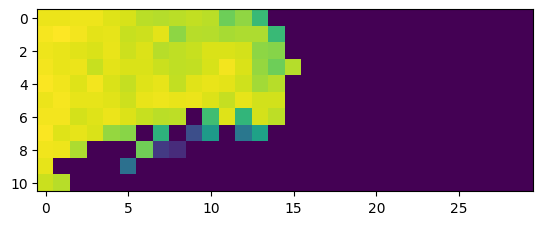

In [34]:
# Optimal search.
B0_range = np.linspace(0, 1.0, 11)   # 0.1 increment.
B1_range = np.linspace(0.1, 3.0, 30)   # 0.1 increment.
LIF2Dopt = np.zeros((B0_range.size, B1_range.size))

for i, B0 in enumerate(B0_range):
    print(i)
    for j, B1 in enumerate(B1_range):
        net = LIF2DNet(B0=B0, B1=B1).to(device)
        _, _, _, acc_rec = TrainSNN(net, nepochs = 1, print_epoch=False)
        LIF2Dopt[i,j] = acc_rec[-1]

for i, B0 in enumerate(B0_range):
    print(i)
    for j, B1 in enumerate(B1_range):
        if LIF2Dopt[i,j] > 60:
            net = LIF2DNet(B0=B0, B1=B1).to(device)
            _, _, _, acc_rec = TrainSNN(net, nepochs = 10, print_epoch=False)
            LIF2Dopt[i,j] = acc_rec[-1]
        else:
            LIF2Dopt[i,j] = 0

print(np.amax(LIF2Dopt))
plt.imshow(LIF2Dopt)

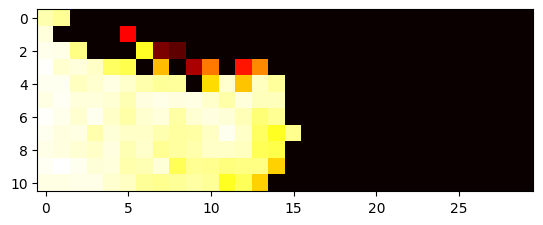

In [35]:
plt.imshow(LIF2Dopt[::-1], cmap = 'hot')

In [39]:
indices = np.where(LIF2Dopt > 95)
indices

(array([1, 1, 1, 3, 3, 4, 4, 5, 6, 6, 7]),
 array([ 0,  1,  2,  0, 11,  0,  3,  1,  0,  1,  0]))

In [37]:
B0_range

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [38]:
B1_range

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])

In [41]:
net = LIF2DNet(B0=0.5, B1=0.5).to(device)
_, _, _, acc_rec = TrainSNN(net, nepochs = 10, print_epoch=True)

Epoch: 1 | Train Loss: 284.8 | Test Loss: 256.9 | Test Accuracy: 85.35%
Epoch: 2 | Train Loss: 117.4 | Test Loss: 128.1 | Test Accuracy: 88.09%
Epoch: 3 | Train Loss: 89.37 | Test Loss: 109.6 | Test Accuracy: 86.91%
Epoch: 4 | Train Loss: 74.94 | Test Loss: 102.0 | Test Accuracy: 89.06%
Epoch: 5 | Train Loss: 64.52 | Test Loss: 100.5 | Test Accuracy: 89.45%
Epoch: 6 | Train Loss: 58.3 | Test Loss: 99.34 | Test Accuracy: 87.30%
Epoch: 7 | Train Loss: 53.99 | Test Loss: 94.86 | Test Accuracy: 87.30%
Epoch: 8 | Train Loss: 50.94 | Test Loss: 95.07 | Test Accuracy: 87.89%
Epoch: 9 | Train Loss: 49.46 | Test Loss: 97.22 | Test Accuracy: 92.38%
Epoch: 10 | Train Loss: 48.23 | Test Loss: 94.55 | Test Accuracy: 90.82%
